## Measure Velocity and Acceleration in the Simulation

In order to use the Kalman "control" parameters for expected acceleration based on the motor settings, we need to measure it in the simulation.
We might be able to figure it out from the code, but it is probably easier to just measure it.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import csv
import numpy as np
from scipy import stats  # for linear fit

In [2]:
# if needed, the path to the PyFRC library
import sys
sys.path.insert(1, '/home/ligerbots/software/kalman/pyfrc/lib')

from pyfrc.physics import motor_cfgs, tankmodel
from pyfrc.physics.units import units

Hi from paul


In [3]:
tstep = 0.05
start_pos = (0, 0, 0)    # x, y, angle

# Define the path
# time, left motor, right motor
velocity_steps = ((0, 0.05, 0.05), (2.0, 0.1, 0.1), (4.0, 0.25, 0.25), (6.0, 0.5, 0.5), (8.0, 0.75, 0.75), (10.0, 1.0, 1.0), (12.0, 0, 0))

In [4]:
bumper_width = 4*units.inch
def create_robot():
    return tankmodel.TankModel.theory(
                motor_cfgs.MOTOR_CFG_CIM,           # motor configuration
                125*units.lbs,                      # robot mass
                10.71,                              # drivetrain gear ratio
                2,                                  # motors per side
                22*units.inch,                      # robot wheelbase
                23*units.inch + bumper_width*2,     # robot width
                32*units.inch + bumper_width*2,     # robot length
                4*units.inch                        # wheel diameter
            )
#robot.inertia = 125*units.lbs * (22*units.inch)**2

In [5]:
def run_curve(path, tstep):
    robot = create_robot()
    time = 0
    path_step = 0
    curr_pos = 6*[0.0, ]
    robot_path = [np.copy(curr_pos), ]
    while True:
        curr_pos[0] += tstep
        if curr_pos[0] >= path[path_step+1][0]:
            path_step += 1
        if path_step == len(path) - 1:
            break
        ctrl = path[path_step]
        delta = robot.get_distance(-ctrl[1], ctrl[2], tstep)
        curr_pos[3] += delta[2]
    
        c = math.cos(curr_pos[3])
        s = math.sin(curr_pos[3])
            
        curr_pos[1] += (delta[0]*c - delta[1]*s)
        curr_pos[2] += (delta[0]*s + delta[1]*c)
        
        curr_pos[4] = ctrl[1]
        curr_pos[5] = ctrl[2]
        robot_path.append(np.copy(curr_pos))
    return robot_path

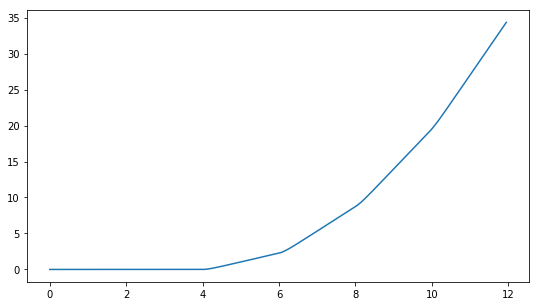

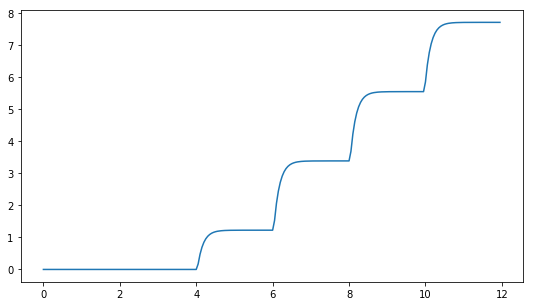

In [6]:
robot_path = run_curve(velocity_steps, tstep)
t = [r[0] for r in robot_path]
x = [r[1] for r in robot_path]
y = [r[2] for r in robot_path]
vx = [0,]
vx.extend(np.diff(x) / tstep)
plt.rcParams['figure.figsize'] = (9,5)
plt.plot(t,x);
plt.show()
plt.plot(t,vx);

## Measure the final velocity of each motor setting. 
Note that there is a minimum motor percent. From the graph, it is about 0.1.

In [7]:
# Use the point a little before the control change, because np.gradient() smooths a bit
vel_pts = [(velocity_steps[i][1], vx[38+i*40]) for i in range(0,len(velocity_steps)-1)]
vel_pts

[(0.05, 0.0),
 (0.1, 0.0),
 (0.25, 1.2258825326796252),
 (0.5, 3.3892081387234185),
 (0.75, 5.552536413251019),
 (1.0, 7.715866467529082)]

In [8]:
res = stats.linregress(vel_pts[2:])
slope = res[0]
intcpt = res[1]
x_intcpt = - intcpt / slope
print('slope =', slope, 'x_int =', x_intcpt )

slope = 8.653312031630389 x_int = 0.1083338527833695


In [9]:
def velocity_expected(ave_motor):
    return max(0, 8.65 * (ave_motor - 0.1083))

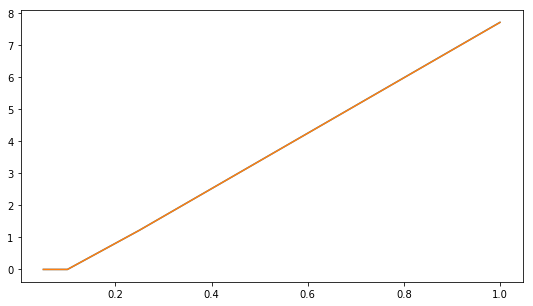

In [10]:
m = [r[0] for r in vel_pts]
plt.plot(m, [r[1] for r in vel_pts])
plt.plot(m, [velocity_expected(p) for p in m]);

# Now measure the acceleration
From the model code, the acceleration is proportional to the difference between the current velocity and the final velocity for that motor power. This means the velocity grows as an exponential to the final value.

Looking more closely, there is something else going on. The first time step after a change is low acceleration, and then it goes up and then down. However, it seems to fit OK.

Let's try getting the value from a fit.

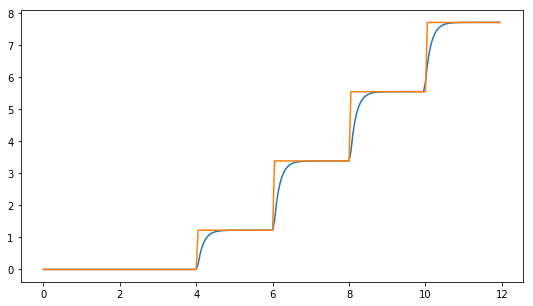

In [11]:
# this needs to be offset by 1 element
expected_v = [0, ]
for i in range(0,len(velocity_steps)-1):
    expected_v.extend([velocity_expected(velocity_steps[i][1]) for ii in range(40)])
expected_v = np.array(expected_v[:240])
plt.plot(t,vx)
plt.plot(t,expected_v);

In [12]:
def vel_from_accel(motor, accel_const):
    v_curr = 0
    v_calc = []
    prev_x = 0
    for m in motor:
        v_expect = velocity_expected(m)
        a = accel_const * (v_expect - v_curr)
        v_curr += a * tstep
        v_calc.append(v_curr)
    return v_calc

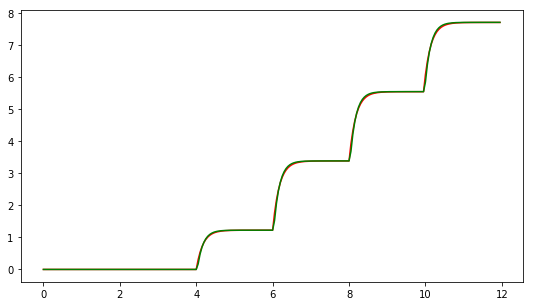

In [13]:
l_motor = [p[4] for p in robot_path]
v_calc = vel_from_accel(l_motor, 5.0)
plt.plot(t, v_calc, color='red')
plt.plot(t, vx, color='green');

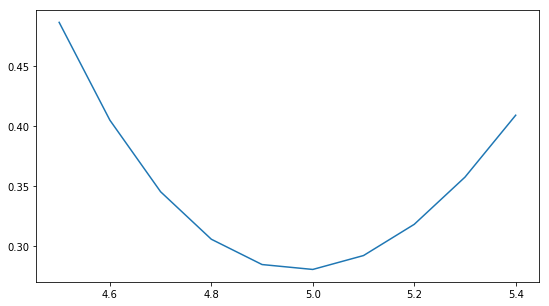

In [14]:
def vel_model(motor, accel_const):
    v_calc = vel_from_accel(motor, accel_const)
    d = np.subtract(vx, v_calc)
    err = np.sum(d*d)
    return err

vals = np.arange(4.5, 5.5, 0.1)
errs = [vel_model(l_motor, v) for v in vals]
plt.plot(vals, errs);

So, use 5.0 for the acceleration factor. Need to investigate the model some more.

# What about rotation?

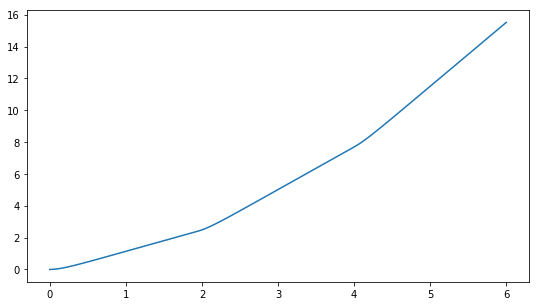

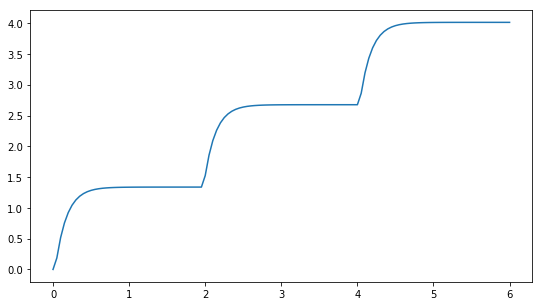

In [15]:
# Define the path
# time, left motor, right motor
angle_steps = ((0.0, 0.5, 0.25), (2.0, 0.75, 0.25), (4.0, 1.0, 0.25), (6.0, 0, 0))
robot_path = run_curve(angle_steps, tstep)
t = [r[0] for r in robot_path]
a = [r[3] for r in robot_path]
omega = [0,]
omega.extend(np.diff(a) / tstep)
plt.rcParams['figure.figsize'] = (9,5)
plt.plot(t,a);
plt.show()
plt.plot(t,omega);

Angle velocity should be computable from the linear velocity of each side motor. Angle change is related to the difference and the wheelbase.

In [16]:
def calc_omega(vl, vr, wb):
    return np.subtract(vl, vr) / wb

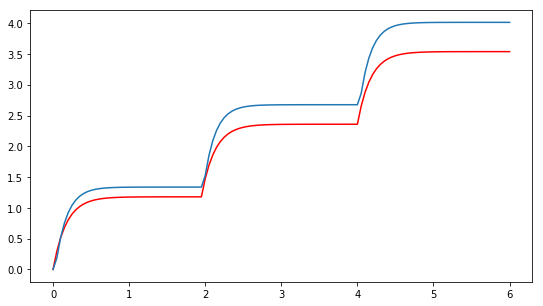

In [17]:
vl = vel_from_accel([p[4] for p in robot_path], 5.0)
vr = vel_from_accel([p[5] for p in robot_path], 5.0)

omega_calc = calc_omega(vl, vr, 22/12.0)
plt.plot(t, omega_calc, color="red")
plt.plot(t, omega)

That seems like what it should be, but looking at the simulation code, that is not quite what they do. (I think that is a bug, but for now, deal with it.)

The simulation computes the turn angle with some kind of arbitrary parameters, supposedly related to the moment of inertia. For now, just do it as an arbitrary parameter.

In [18]:
def calc_omega(vl, vr, factor):
    return factor * np.subtract(vl, vr)

omega factor = 0.6218181818181818


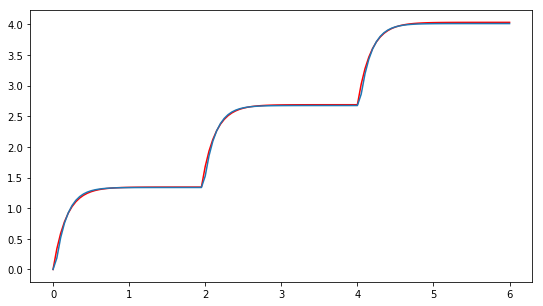

In [19]:
vl = vel_from_accel([p[4] for p in robot_path], 5.0)
vr = vel_from_accel([p[5] for p in robot_path], 5.0)

omega_factor = 1.14* 12 / 22
print("omega factor =", omega_factor)
omega_calc = calc_omega(vl, vr, omega_factor)
plt.plot(t, omega_calc, color="red")
plt.plot(t, omega);

Need to base the calc on something we can easily maintain in the real filter: motor settings and state. We don't track the separate motor speeds.

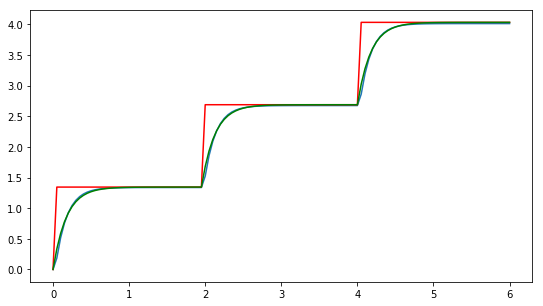

In [20]:
def omega_max(motor_l, motor_r, factor):
    v_l = velocity_expected(motor_l)
    v_r = velocity_expected(motor_r)
    return calc_omega(v_l, v_r, factor)

def a_omega_func(motor_l, motor_r, prev_omega, rotation_factor, accel_frac):
    omega_m = omega_max(motor_l, motor_r, rotation_factor)
    return accel_frac * (omega_m - prev_omega)

def omega_from_motors(robot_path, accel_factor):
    o_curr = 0
    omega_calc = []
    for p in robot_path:
        a_calc = a_omega_func(p[4], p[5], o_curr, omega_factor, accel_factor )
        o_curr += a_calc * tstep
        omega_calc.append(o_curr)
    return omega_calc

max_omega = [omega_max(p[4], p[5], omega_factor) for p in robot_path]
plt.plot(t, omega)
plt.plot(t, max_omega, color="red")
plt.plot(t, omega_calc, color='green');

Looks like the same factor "5" we saw for linear acceleration. Let's check

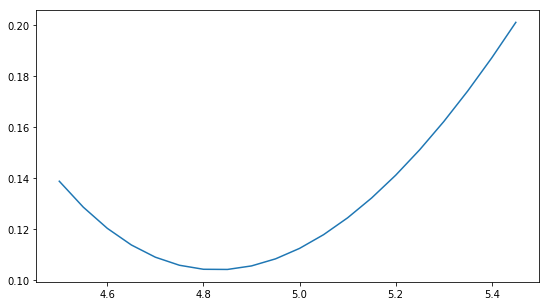

In [21]:
def omega_error(omega, robot_path, accel_factor):
    omega_calc = omega_from_motors(robot_path, accel_factor)
    d = np.subtract(omega, omega_calc)
    err = np.sum(d*d)
    return err

vals = np.arange(4.5, 5.5, 0.05)
errs = [omega_error(omega, robot_path, v) for v in vals]
plt.plot(vals, errs);

Optimum looks to be 4.8